# Quantum Inspire performance test

We compare performance of the simulator with the circuit from 

"Overview and Comparison of Gate Level Quantum Software Platforms", https://arxiv.org/abs/1807.02500

Pieter Eendebak <pieter.eendebak@tno.nl>

# Define the circuit

In [1]:
from IPython.display import Math
import numpy as np
import itertools
import warnings
from colorama import Fore
from imp import reload
from getpass import getpass

# importing the QISKit
import qiskit
from qiskit.tools.visualization import circuit_drawer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.tools.qi.qi import state_fidelity, concurrence, purity, outer
from qiskit.tools.visualization import plot_state, plot_histogram
from sympy.interactive import printing
printing.init_printing(use_latex='png')
from IPython.display import display, Math, Latex

from requests.auth import HTTPBasicAuth
from quantuminspire import QuantumInspireAPI
from quantuminspire.qitools import format_vector, run_circuit

We define the circuit based on the number of qubits and the depth (e.g. the number of iterations of the unit building block).

None

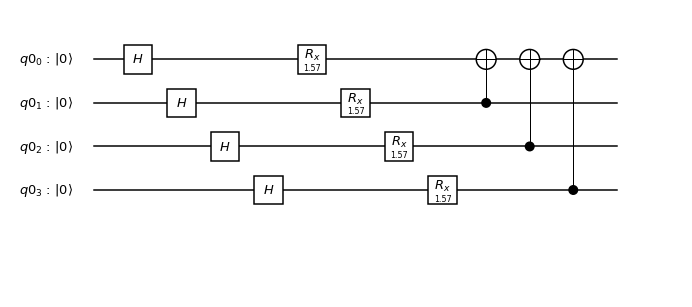

In [2]:
def pcircuit(nqubits, depth = 10):
    q = QuantumRegister(nqubits)
    qc = QuantumCircuit(q)

    for level in range(depth):
        for qidx in range(nqubits):
            qc.h( q[qidx] )
        qc.barrier()
        for qidx in range(nqubits):
            qc.rx(np.pi/2, q[qidx])
        qc.barrier()
            
        for qidx in range(nqubits):
            if qidx!=0:
                qc.cx(q[qidx], q[0])
                
    return q, qc

q,qc=pcircuit(4, 1)
cplot=circuit_drawer(qc)
display(cplot)

# Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [5]:
try:
    passwd
except:
    print('Enter username')
    username = input();
    print('Enter password')
    passwd = getpass();

auth = HTTPBasicAuth(username, passwd)
qi = QuantumInspireAPI(server=r'https://api.quantum-inspire.com/', auth=auth)  
_=qi.list_backend_types()

backend: QX Single-node Simulator (qubits 26)
backend: QX Single-node Simulator SurfSara (qubits 31)
backend: QX Multi-node Simulator (qubits 37)
backend: 10-Qubit NV Center (qubits 10)
backend: 17-Qubit Transmon (qubits 17)
backend: 2-Qubit Silicon Spin (qubits 2)
backend: 5-Qubit Silicon Spin (qubits 5)


We create a QisKit backend for the Quantum Inspire interface and execute the circuit generated above.

In [6]:
from quantuminspire.qiskit.qiskit_backend import QiSimulatorPy
backend=QiSimulatorPy(qi_api=qi)    
j=execute(qc, backend)

no measurements in circuit 'circuit1', classical register will remain all zeros.


backend: QX Single-node Simulator (qubits 26)
backend: QX Single-node Simulator SurfSara (qubits 31)
backend: QX Multi-node Simulator (qubits 37)
backend: 10-Qubit NV Center (qubits 10)
backend: 17-Qubit Transmon (qubits 17)
backend: 2-Qubit Silicon Spin (qubits 2)
backend: 5-Qubit Silicon Spin (qubits 5)
run_circuit: number_of_shots 1024
generate_cqasm: 4 qubits

submitting qasm code to quantum inspire qi-sdk-job-97ffc026-970a-11e8-8385-0800271e4a8b
waiting for result of job 363 (iteration 0)
waiting for result of job 363 (iteration 1)
waiting for result of job 363 (iteration 2)
waiting for result of job 363 (iteration 3)
waiting for result of job 363 (iteration 4)
waiting for result of job 363 (iteration 5)
waiting for result of job 363 (iteration 6)
waiting for result of job 363 (iteration 7)
waiting for result of job 363 (iteration 8)
waiting for result of job 363 (iteration 9)
waiting for result of job 363 (iteration 10)
waiting for result of job 363 (iteration 11)
waiting for res

We can print the results and also show the cQASM that was generated.

In [7]:
print(Fore.BLUE+'Generated histogram:' + Fore.RESET)
print(j.get_counts())
print(Fore.BLUE+'Generated cQASM:' + Fore.RESET)
print(backend._cqasm[0:101] + '\n....\n' + backend._cqasm[-100:])

Generated histogram:
{'2': 57.0, '5': 71.0, '12': 77.0, '9': 64.0, '13': 56.0, '15': 65.0, '10': 68.0, '0': 68.0, '11': 66.0, '8': 66.0, '7': 87.0, '3': 56.0, '6': 58.0, '4': 62.0, '1': 56.0, '14': 47.0}
Generated cQASM:
version 1.0
# cqasm generated by QI backend for QisKit
qubits 4
H q[3]
H q[2]
H q[1]
H q[0]
Rz q[0], 
....
, q[0]
CNOT q[3], q[0]
.measurement
   measure q[0]
   measure q[1]
   measure q[2]
   measure q[3]



Visualization can be done with the normal Python plotting routines, or with the QisKit SDK.

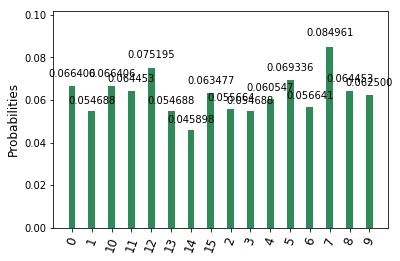

In [8]:
plot_histogram(j.get_counts(qc))

To compare we will run the circuit with 20 qubits and depth 20. This takes:

* QisKit: 3.7 seconds
* ProjectQ: 2.0 seconds

In [9]:
q,qc=pcircuit(20, 20)
j=execute(qc, backend)

no measurements in circuit 'circuit2', classical register will remain all zeros.


run_circuit: number_of_shots 1024
generate_cqasm: 20 qubits

submitting qasm code to quantum inspire qi-sdk-job-c11aec10-970a-11e8-8385-0800271e4a8b
waiting for result of job 364 (iteration 0)
waiting for result of job 364 (iteration 1)
waiting for result of job 364 (iteration 2)
waiting for result of job 364 (iteration 3)
waiting for result of job 364 (iteration 4)
waiting for result of job 364 (iteration 5)
waiting for result of job 364 (iteration 6)
waiting for result of job 364 (iteration 7)
waiting for result of job 364 (iteration 8)
waiting for result of job 364 (iteration 9)
waiting for result of job 364 (iteration 10)
waiting for result of job 364 (iteration 11)
waiting for result of job 364 (iteration 12)
waiting for result of job 364 (iteration 13)
waiting for result of job 364 (iteration 14)
waiting for result of job 364 (iteration 15)
waiting for result of job 364 (iteration 16)
waiting for result of job 364 (iteration 17)
waiting for result of job 364 (iteration 18)
waitin

waiting for result of job 364 (iteration 178)
waiting for result of job 364 (iteration 179)
waiting for result of job 364 (iteration 180)
waiting for result of job 364 (iteration 181)
waiting for result of job 364 (iteration 182)
waiting for result of job 364 (iteration 183)
waiting for result of job 364 (iteration 184)
waiting for result of job 364 (iteration 185)
waiting for result of job 364 (iteration 186)
waiting for result of job 364 (iteration 187)
waiting for result of job 364 (iteration 188)
waiting for result of job 364 (iteration 189)
waiting for result of job 364 (iteration 190)
waiting for result of job 364 (iteration 191)
waiting for result of job 364 (iteration 192)
waiting for result of job 364 (iteration 193)
waiting for result of job 364 (iteration 194)
waiting for result of job 364 (iteration 195)
waiting for result of job 364 (iteration 196)
waiting for result of job 364 (iteration 197)
waiting for result of job 364 (iteration 198)
waiting for result of job 364 (ite

TypeError: 'NoneType' object is not subscriptable

## Notes

The implementation of the $sqrt(X)$ gate was done a series of $R_z$ and $R_y$ rotations.

In [8]:
# decompose U from 
#https://quantumexperience.ng.bluemix.net/qx/tutorial?sectionId=full-user-guide&page=002-The_Weird_and_Wonderful_World_of_the_Qubit~2F004-advanced_qubit_gates
I=1j
from numpy import cos, sin
import sympy as sp
from sympy import exp,pprint
from sympy.functions.elementary.trigonometric import cos,sin

theta,psi,phi,l = sp.symbols('theta psi phi lambda')

A=np.matrix([[1,0],[0,sp.exp(I*phi)]])
B=np.matrix([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
C=np.matrix([[1,0],[0,sp.exp(I*l)]])
pprint(A*B*C)


               [[cos(theta/2) -exp(1.0*I*lambda)*sin(theta/2)]               
 [exp(1.0*I*phi)*sin(theta/2) exp(1.0*I*lambda)*exp(1.0*I*phi)*cos(theta/2)]]
